In [1]:
import os
import numpy
import h5py
from scipy.misc import logsumexp
import tqdm
import pickle
import hom2m
import wendypy
import wendym2m
from galpy.util import bovy_plot, save_pickles
%pylab inline
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
numpy.random.seed(4)
import copy
import matplotlib.animation as animation
from matplotlib import gridspec
from IPython.display import HTML, Image
import seaborn as sns
from scipy.optimize import curve_fit
tc= sns.color_palette('colorblind')
init_color= sns.color_palette()[0]
final_color= tc[2]
constraint_color= tc[1]
save_figures= True
save_chain_figures= False
_SAVE_GIFS= False
rcParams.update({'axes.labelsize': 17.,
              'font.size': 12.,
              'legend.fontsize': 17.,
              'xtick.labelsize':15.,
              'ytick.labelsize':15.,
              'text.usetex': _SAVE_GIFS,
              'figure.figsize': [5,5],
              'xtick.major.size' : 4,
              'ytick.major.size' : 4,
              'xtick.minor.size' : 2,
              'ytick.minor.size' : 2,
              'legend.numpoints':1})
import copy
numpy.random.seed(2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%aimport wendym2m
%aimport hom2m
%autoreload 1

# M2M with one-dimensional self-gravity with an external potential taking into account number/mass density ratio, $X_{nm}$

# Read target disk file and do M2M

Here we investigate M2M with one-dimensional self-gravity and a constant density background, taking into account number/mass density ratio, which is defined with Xnm. We will use the target disk data generated by Generate_disk.ipynb. 

For an external potential, we consider that in the solar neighborhood dark matter is an approximately constant density $\rho_{\mathrm{DM}} = $ constant.

This density corresponds to a potential $\Phi_{\mathrm{DM}} = \omega^2 z^2 / 2$, with $\omega = \sqrt{4\pi\,G\,\rho_{\mathrm{DM}}}$.

We set $\rho_{\mathrm{DM}}=1$, i.e. equivalent to the disk mass, and therfore $\omega = 1/\sqrt{2}$. 

We consider that the observed density is number density of stars, but in M2M model, each element's $w$ traces mass. Here, we assume the number and mass denity ratio of $X_{nm}$, and fit it as well.

### Unperturbed disk

First let's read 'target_disk_unperturbed.h5', and run M2M for the unperturbed target disk.

In [26]:
# read the target disk file
with h5py.File('target_disk_unperturbed.h5', 'r') as f:
    n_mock = f['N'].value
    totmass_true = f['Mtot'].value
    sigma_true = f['sigma'].value
    omegadm_true = f['omega'].value
    z_mock = f['z'].value
    vz_mock = f['vz'].value
    m_mock = f['m'].value

print(' N, Mtot, sigma, omega=', n_mock, totmass_true, sigma_true, omegadm_true)

 N, Mtot, sigma, omega= 100000 1.0 1.0 0.7071067811865475


In [27]:
zh_true = sigma_true**2./totmass_true  # Where 2\pi G= 1 so units of zh are ~311 pc
tdyn = zh_true/sigma_true
z_init, vz_init, m_init = wendym2m.sample_sech2(
    sigma_true, totmass_true, n=n_init)
print('zh, tdyn, omega_dm =', zh_true, tdyn, omegadm_true)

zh, tdyn, omega_dm = 1.0 1.0 0.7071067811865475


We will set up the target.

In [28]:
totmass_true = numpy.sum(m_mock)
omegadm = copy.deepcopy(omegadm_true)
print('Totmass =', totmass_true) 

Totmass = 1.0


Let's plot z vs. vz

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)



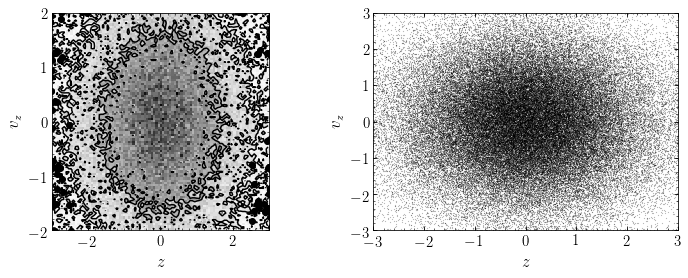

In [29]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.scatterplot(z_mock,vz_mock,'ko',
                   xlabel=r'$z$',ylabel=r'$v_z$',
                   xrange=[-3.0, 3.0],yrange=[-2.0,2.0],gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(z_mock,vz_mock,'ko', 0.1,
                   xlabel=r'$z$',ylabel=r'$v_z$',
                   xrange=[-3.0, 3.0],yrange=[-3.0,3.0],gcf=True, markersize=0.1)


Let's plot the density profile. 

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")



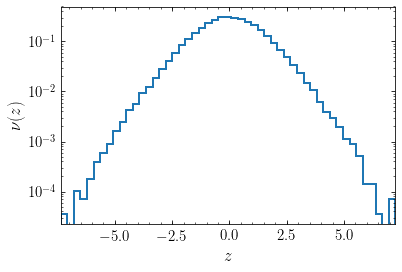

In [30]:
figsize(6,4)
_= bovy_plot.bovy_hist(z_mock,bins=51,normed=True,
                       xlabel=r'$z$',ylabel=r'$\nu(z)$',lw=2.,
                       histtype='step')
gca().set_yscale('log')

Now we 'observe' this density distribution from $z_{\mathrm{sun}} = 0$ and $X_{nm}=0.1$:

In [31]:
zsun_true= 0.0
xnm_true = 0.1
# We only observe the density at a few z
# z_obs= numpy.array([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0,
#                    0. -0.2, -0.4, -0.6, -0.8, -1.0, -1.2,
#                    -1.4, -1.6, -1.8, -2.0])
# z_obs= numpy.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
#                    0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 
#                    1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 
#                    1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0,
#                    -0.05, -0.1, -0.15, -0.2, -0.25, -0.3, -0.35, -0.4, -0.45, -0.5,
#                    -0.55, -0.6, -0.65, -0.7, -0.75, -0.8, -0.85, -0.9, -0.95, -1.0,
#                    -1.05, -1.1, -1.15, -1.2, -1.25, -1.3, -1.35, -1.4, -1.45, -1.5,
#                    -1.55, -1.6, -1.65, -1.7, -1.75, -1.8, -1.85, -1.9, -1.95, -2.0,])
# z_obs= numpy.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
#                      -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0])
# h_obs= 0.1
# z_obs= numpy.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3,
#                     -0.1, -0.3, -0.5, -0.7, -0.9, -1.1, 1.3])
z_obs= numpy.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9,
                     2.1, 2.3, 2.5, 2.7, 2.9, 3.1,
                    -0.1, -0.3, -0.5, -0.7, -0.9, -1.1, -1.3, -1.5, -1.7, -1.9,
                   -2.1, -2.3, -2.5, -2.7, -2.9, -3.1])
h_obs= 0.2
# z_obs= numpy.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 
#                     1.1, 1.2, 1.3, 1.4, 1.5, 
#                    -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0,
#                    -1.1, -1.2, -1.3, -1.4, -1.5])
#h_obs = 0.1
dens_obs= xnm_true*hom2m.compute_dens(z_mock,zsun_true,z_obs,h_obs,w=m_mock)
# dens_obs_noise= numpy.sqrt(dens_obs)*0.2*numpy.sqrt(numpy.amax(dens_obs))\
#    /(numpy.fabs(z_obs**2)/numpy.amin(numpy.fabs(z_obs**2)))
dens_obs_noise= 0.01*dens_obs/numpy.sqrt(dens_obs)
dens_obs+= numpy.random.normal(size=dens_obs.shape)*dens_obs_noise

The observed density is:

<ErrorbarContainer object of 3 artists>

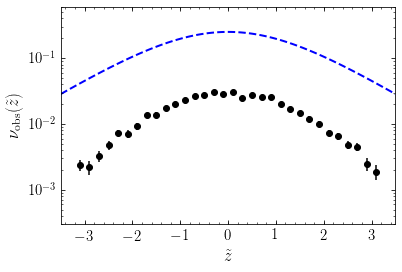

In [32]:
zmin = -3.5
zmax = 3.5
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax], yrange=[xnm_true*0.003, xnm_true*6.])
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color='k')

We also 'observe' the mean of the squared velocity:

In [33]:
# We only observe the v2 at a few z (same as before)
v2_obs= hom2m.compute_v2(z_mock,vz_mock,zsun_true,z_obs,h_obs)
# use constant noise
# v2_obs_noise=numpy.zeros_like(v2_obs)+0.002
v2_obs_noise=numpy.zeros_like(v2_obs)+0.01
numpy.random.seed(10) # probably best to set a seed somewhere so the data is always the same
v2_obs+= numpy.random.normal(size=v2_obs.shape)*v2_obs_noise

<ErrorbarContainer object of 3 artists>

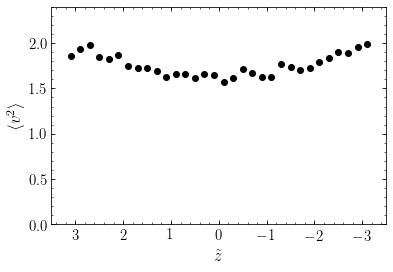

In [34]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v2_obs,'ko',
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle$',
                   xrange=[zmax, zmin],yrange=[0.0,2.4],gcf=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color='k')

We also 'observe' the mean velocity:

In [35]:
# We only observe the v2 at a few z (same as before)
v_obs= hom2m.compute_v(z_mock,vz_mock,zsun_true,z_obs,h_obs)
# use constant noise
v_obs_noise=numpy.zeros_like(v_obs)+0.01
numpy.random.seed(10) # probably best to set a seed somewhere so the data is always the same
v_obs+= numpy.random.normal(size=v_obs.shape)*v_obs_noise

<ErrorbarContainer object of 3 artists>

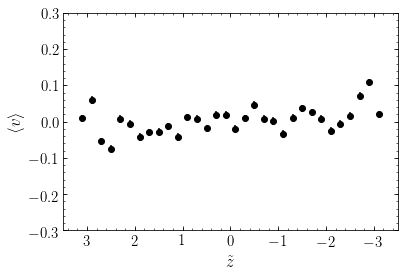

In [36]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v_obs,'ko',
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v\rangle$',
                   xrange=[zmax, zmin],yrange=[-0.3,0.3],gcf=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color='k')

Now we fit the density profile with $\mathrm{sech}^2$ profile.

fit parameter a, b, c= [0.03024735 0.81958161 0.00938839]


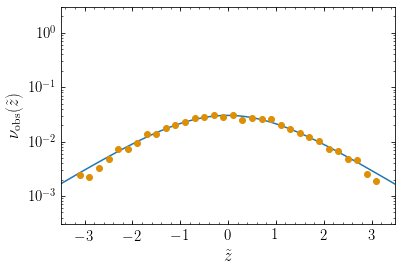

In [37]:
# define sech2 profile
def func_sech2(x, a, b, c):
    return a/(numpy.cosh((x+c)/(2.0*b))**2)
# fit the density with a sech2 profile
popt, pconv = curve_fit(func_sech2, z_obs, dens_obs, bounds=(0, 100))
print('fit parameter a, b, c=', popt)
z_out= numpy.linspace(zmin, zmax, 101)
dens_fit= func_sech2(z_out, *popt)
# plot 
figsize(6,4)
bovy_plot.bovy_plot(z_out, dens_fit,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[xnm_true*0.003,xnm_true*30.],gcf=True)
bovy_plot.bovy_plot(z_obs, dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
yscale('log',nonposy='clip')

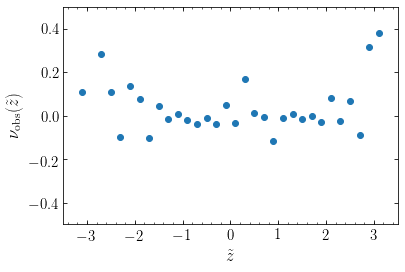

In [38]:
# plot the density differences
dens_fit_obs = func_sech2(z_obs, *popt)
dens_diff = (dens_fit_obs-dens_obs)/dens_obs
# plot 
figsize(6,4)
bovy_plot.bovy_plot(z_obs, dens_diff,'o', color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[-0.5, 0.5],gcf=True)
yscale('linear',nonposy='clip')

Now we load all of this data into the ``data_dicts`` format for specifying the data for M2M:

In [39]:
dens_data= {'type':'dens','pops':0,'zobs':z_obs,'obs':dens_obs,'unc':dens_obs_noise,'zrange':1.}
v2_data= {'type':'v2','pops':0,'zobs':z_obs,'obs':v2_obs,'unc':v2_obs_noise,'zrange':1.}
v_data= {'type':'v','pops':0,'zobs':z_obs,'obs':v_obs,'unc':v_obs_noise,'zrange':1.}
data_dicts= [dens_data,v2_data]
print('zobs=',data_dicts['type'=='dens']['zobs'])

zobs= [ 0.1  0.3  0.5  0.7  0.9  1.1  1.3  1.5  1.7  1.9  2.1  2.3  2.5  2.7
  2.9  3.1 -0.1 -0.3 -0.5 -0.7 -0.9 -1.1 -1.3 -1.5 -1.7 -1.9 -2.1 -2.3
 -2.5 -2.7 -2.9 -3.1]


## M2M fit

We will fit the density and velocity profiles with Wendy M2M with known $z_{\odot}$ and $\omega_{DM}$.

sigma true = 1.0  model initial = 1.1


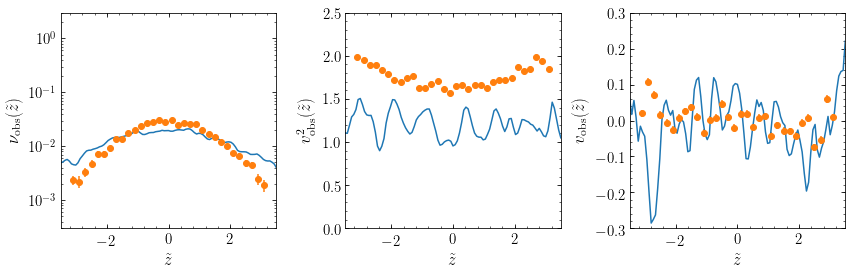

In [40]:
n_m2m= 4000
sigma_init= 1.1
print('sigma true =', sigma_true, ' model initial =', sigma_init)
h_m2m= 0.2
z_m2m, vz_m2m, w_init= wendym2m.sample_sech2(sigma_init,totmass_true,n=n_m2m)
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= xnm_true*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
v_init= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[xnm_true*0.003, xnm_true*30.])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,3,2)
bovy_plot.bovy_plot(z_out,v2_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$v^2_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[0.0,2.5])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
subplot(1,3,3)
bovy_plot.bovy_plot(z_out,v_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$v_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[-0.3,0.3])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])


tight_layout()

### Run without any smoothing:

In [41]:
# step size for particle integration
step= 0.05*tdyn
nstep= 2000
#eps= 10.**-3.5
eps = 10.0**-7.0
smooth= None #1./step/100.
st96smooth= False
mu= 0.0
h_m2m= 0.2
omega_m2m= omegadm_true
zsun_m2m= zsun_true
xnm_m2m = xnm_true
prior= 'entropy'
use_v2=True
w_out,z_m2m,vz_m2m,Q,wevol,windx= \
    wendym2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,data_dicts,npop=1,
                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                     smooth=smooth,st96smooth=st96smooth,output_wevolution=10,
                     number_density=True, xnm_m2m=xnm_m2m)
w_out= w_out[:,0]

 total mass = 1.0055981924490247
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")

Velocity dispersions: mock, fit 1.3007868005302026 1.2945382249721293
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled ax

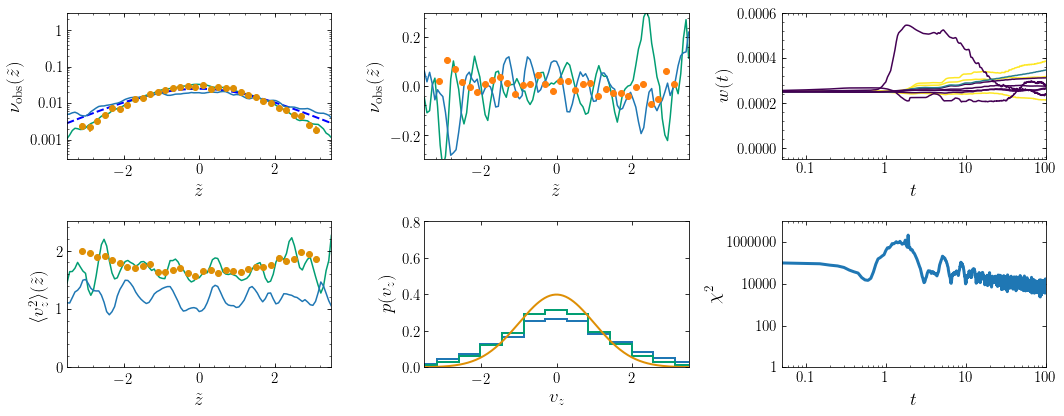

In [42]:
print(' total mass =', numpy.sum(w_out))
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= xnm_m2m*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
v_final= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[xnm_true*0.003,xnm_true*30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, xnm_true*totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[0.0,2.5],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
bovy_plot.bovy_plot(z_out,v_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[-0.3,0.3])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
bovy_plot.bovy_plot(z_out,v_final,'-',overplot=True,zorder=0,color=final_color)
subplot(2,3,5)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
xs= numpy.linspace(zmin, zmax, 201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(zmin, zmax)
ylim(0.,0.8)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
                        color=cm.viridis(z_m2m[windx][ii]/0.3),
                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**7.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()

## Perturbed disk

Let's read 'target_disk_perturbed.h5', and run M2M for the perturbed target disk.

In [51]:
# read the target disk file
with h5py.File('target_disk_perturbed.h5', 'r') as f:
    n_mock = f['N'].value
    totmass_true = f['Mtot'].value
    sigma_true = f['sigma'].value
    omegadm_true = f['omega'].value
    z_mock = f['z'].value
    vz_mock = f['vz'].value
    m_mock = f['m'].value

print(' N, Mtot, sigma, omega=', n_mock, totmass_true, sigma_true, omegadm_true)

 N, Mtot, sigma, omega= 100000 1.0 1.0 0.7071067811865475


In [52]:
zh_true = sigma_true**2./totmass_true  # Where 2\pi G= 1 so units of zh are ~311 pc
tdyn = zh_true/sigma_true
z_init, vz_init, m_init = wendym2m.sample_sech2(
    sigma_true, totmass_true, n=n_init)
print('zh, tdyn, omega_dm =', zh_true, tdyn, omegadm_true)

zh, tdyn, omega_dm = 1.0 1.0 0.7071067811865475


In [53]:
totmass_true = numpy.sum(m_mock)
omegadm = copy.deepcopy(omegadm_true)
print('Totmass =', totmass_true) 

Totmass = 1.0


/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)



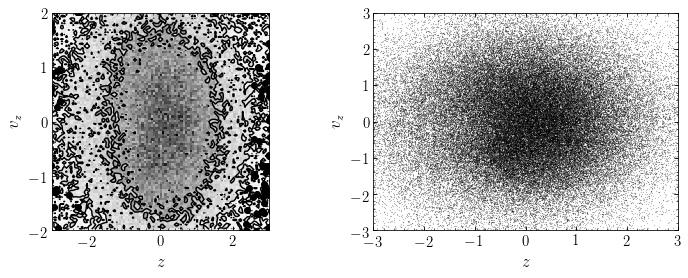

In [54]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.scatterplot(z_mock,vz_mock,'ko',
                   xlabel=r'$z$',ylabel=r'$v_z$',
                   xrange=[-3.0, 3.0],yrange=[-2.0,2.0],gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(z_mock,vz_mock,'ko', 0.1,
                   xlabel=r'$z$',ylabel=r'$v_z$',
                   xrange=[-3.0, 3.0],yrange=[-3.0,3.0],gcf=True, markersize=0.1)



Let's plot the density profile. 

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")



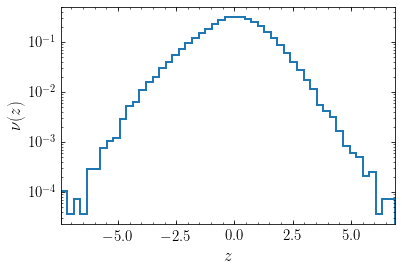

In [55]:
figsize(6,4)
_= bovy_plot.bovy_hist(z_mock,bins=51,normed=True,
                       xlabel=r'$z$',ylabel=r'$\nu(z)$',lw=2.,
                       histtype='step')
gca().set_yscale('log')

Now we 'observe' this density distribution from $z_{\mathrm{sun}} = 0$ and $X_{nm}=0.1$:

In [56]:
zsun_true= 0.0
xnm_true = 0.1
z_obs= numpy.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9,
                     2.1, 2.3, 2.5, 2.7, 2.9, 3.1,
                    -0.1, -0.3, -0.5, -0.7, -0.9, -1.1, -1.3, -1.5, -1.7, -1.9,
                   -2.1, -2.3, -2.5, -2.7, -2.9, -3.1])
h_obs= 0.2
dens_obs= xnm_true*hom2m.compute_dens(z_mock,zsun_true,z_obs,h_obs,w=m_mock)
# dens_obs_noise= numpy.sqrt(dens_obs)*0.2*numpy.sqrt(numpy.amax(dens_obs))\
#    /(numpy.fabs(z_obs**2)/numpy.amin(numpy.fabs(z_obs**2)))
dens_obs_noise= 0.01*dens_obs/numpy.sqrt(dens_obs)
dens_obs+= numpy.random.normal(size=dens_obs.shape)*dens_obs_noise

<ErrorbarContainer object of 3 artists>

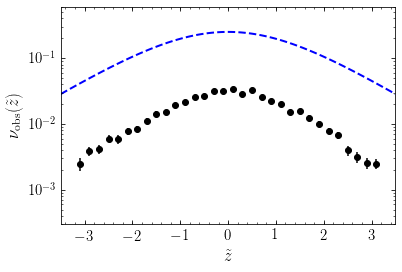

In [57]:
zmin = -3.5
zmax = 3.5
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax], yrange=[xnm_true*0.003, xnm_true*6.])
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color='k')

We also 'observe' the mean of the squared velocity:

In [58]:
# We only observe the v2 at a few z (same as before)
v2_obs= hom2m.compute_v2(z_mock,vz_mock,zsun_true,z_obs,h_obs)
# use constant noise
# v2_obs_noise=numpy.zeros_like(v2_obs)+0.002
v2_obs_noise=numpy.zeros_like(v2_obs)+0.01
numpy.random.seed(10) # probably best to set a seed somewhere so the data is always the same
v2_obs+= numpy.random.normal(size=v2_obs.shape)*v2_obs_noise

<ErrorbarContainer object of 3 artists>

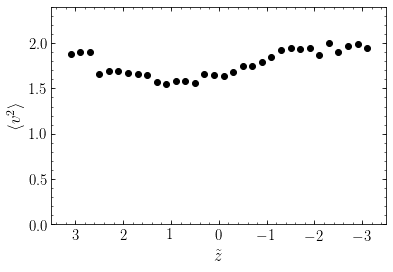

In [59]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v2_obs,'ko',
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle$',
                   xrange=[zmax, zmin],yrange=[0.0,2.4],gcf=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color='k')

We also 'observe' the mean velocity:

In [60]:
# We only observe the v2 at a few z (same as before)
v_obs= hom2m.compute_v(z_mock,vz_mock,zsun_true,z_obs,h_obs)
# use constant noise
v_obs_noise=numpy.zeros_like(v_obs)+0.01
numpy.random.seed(10) # probably best to set a seed somewhere so the data is always the same
v_obs+= numpy.random.normal(size=v_obs.shape)*v_obs_noise

<ErrorbarContainer object of 3 artists>

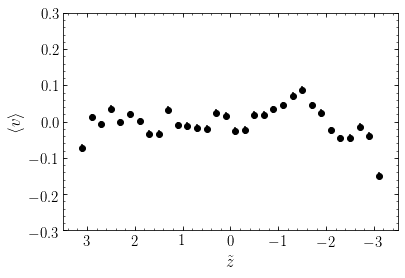

In [61]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v_obs,'ko',
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v\rangle$',
                   xrange=[zmax, zmin],yrange=[-0.3,0.3],gcf=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color='k')

Now we fit the density profile with $\mathrm{sech}^2$ profile.

fit parameter a, b, c= [3.17106554e-02 7.74960837e-01 6.86827044e-15]


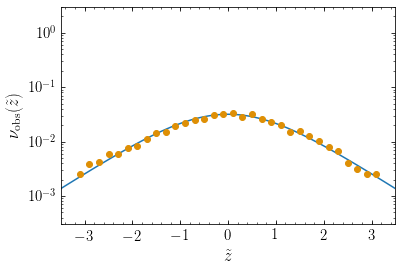

In [62]:
# define sech2 profile
def func_sech2(x, a, b, c):
    return a/(numpy.cosh((x+c)/(2.0*b))**2)
# fit the density with a sech2 profile
popt, pconv = curve_fit(func_sech2, z_obs, dens_obs, bounds=(0, 100))
print('fit parameter a, b, c=', popt)
z_out= numpy.linspace(zmin, zmax, 101)
dens_fit= func_sech2(z_out, *popt)
# plot 
figsize(6,4)
bovy_plot.bovy_plot(z_out, dens_fit,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[xnm_true*0.003,xnm_true*30.],gcf=True)
bovy_plot.bovy_plot(z_obs, dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
yscale('log',nonposy='clip')

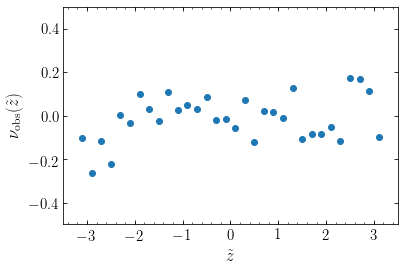

In [63]:
# plot the density differences
dens_fit_obs = func_sech2(z_obs, *popt)
dens_diff = (dens_fit_obs-dens_obs)/dens_obs
# plot 
figsize(6,4)
bovy_plot.bovy_plot(z_obs, dens_diff,'o', color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[-0.5, 0.5],gcf=True)
yscale('linear',nonposy='clip')

Now we load all of this data into the ``data_dicts`` format for specifying the data for M2M:

In [64]:
dens_data= {'type':'dens','pops':0,'zobs':z_obs,'obs':dens_obs,'unc':dens_obs_noise,'zrange':1.}
v2_data= {'type':'v2','pops':0,'zobs':z_obs,'obs':v2_obs,'unc':v2_obs_noise,'zrange':1.}
v_data= {'type':'v','pops':0,'zobs':z_obs,'obs':v_obs,'unc':v_obs_noise,'zrange':1.}
data_dicts= [dens_data,v2_data]
print('zobs=',data_dicts['type'=='dens']['zobs'])

zobs= [ 0.1  0.3  0.5  0.7  0.9  1.1  1.3  1.5  1.7  1.9  2.1  2.3  2.5  2.7
  2.9  3.1 -0.1 -0.3 -0.5 -0.7 -0.9 -1.1 -1.3 -1.5 -1.7 -1.9 -2.1 -2.3
 -2.5 -2.7 -2.9 -3.1]


## M2M fit for a perturbed disk

We will fit the density and velocity profiles with Wendy M2M with known $z_{\odot}$ and $\omega_{DM}$.

sigma true = 1.0  model initial = 1.1


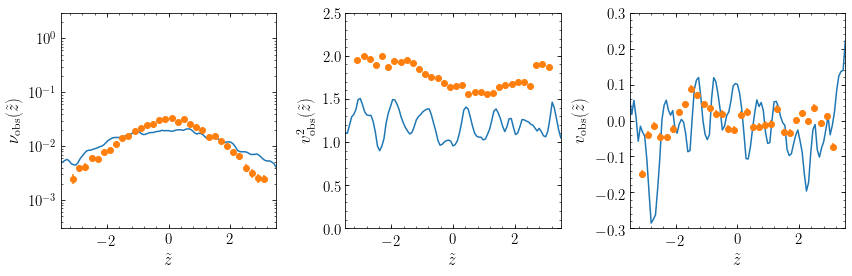

In [66]:
n_m2m= 4000
sigma_init= 1.1
print('sigma true =', sigma_true, ' model initial =', sigma_init)
h_m2m= 0.2
z_m2m, vz_m2m, w_init= wendym2m.sample_sech2(sigma_init,totmass_true,n=n_m2m)
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= xnm_true*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
v_init= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[xnm_true*0.003, xnm_true*30.])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,3,2)
bovy_plot.bovy_plot(z_out,v2_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$v^2_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[0.0,2.5])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
subplot(1,3,3)
bovy_plot.bovy_plot(z_out,v_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$v_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[-0.3,0.3])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])


tight_layout()

### Run M2M

In [67]:
# step size for particle integration
step= 0.05*tdyn
nstep= 2000
#eps= 10.**-3.5
eps = 10.0**-7.0
smooth= None #1./step/100.
st96smooth= False
mu= 0.0
h_m2m= 0.2
omega_m2m= omegadm_true
zsun_m2m= zsun_true
xnm_m2m = xnm_true
prior= 'entropy'
use_v2=True
w_out,z_m2m,vz_m2m,Q,wevol,windx= \
    wendym2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,data_dicts,npop=1,
                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                     smooth=smooth,st96smooth=st96smooth,output_wevolution=10,
                     number_density=True, xnm_m2m=xnm_m2m)
w_out= w_out[:,0]

 total mass = 1.0060897042990653
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")

Velocity dispersions: mock, fit 1.3110158981565752 1.3046096719677254
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled ax

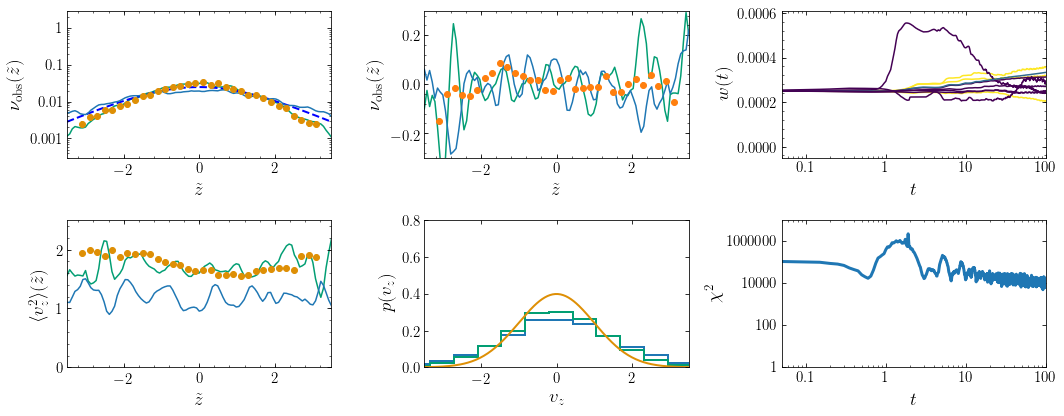

In [68]:
print(' total mass =', numpy.sum(w_out))
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= xnm_m2m*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
v_final= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[xnm_true*0.003,xnm_true*30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, xnm_true*totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[0.0,2.5],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
bovy_plot.bovy_plot(z_out,v_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[-0.3,0.3])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
bovy_plot.bovy_plot(z_out,v_final,'-',overplot=True,zorder=0,color=final_color)
subplot(2,3,5)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
xs= numpy.linspace(zmin, zmax, 201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(zmin, zmax)
ylim(0.,0.8)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
                        color=cm.viridis(z_m2m[windx][ii]/0.3),
                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**7.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()